**Step 1: Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

**Step 2: Load Dataset**

In [2]:
df = pd.read_csv("/kaggle/input/iriscsv/Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
df.drop(columns=["Id"], inplace=True)

**Data Visualization**

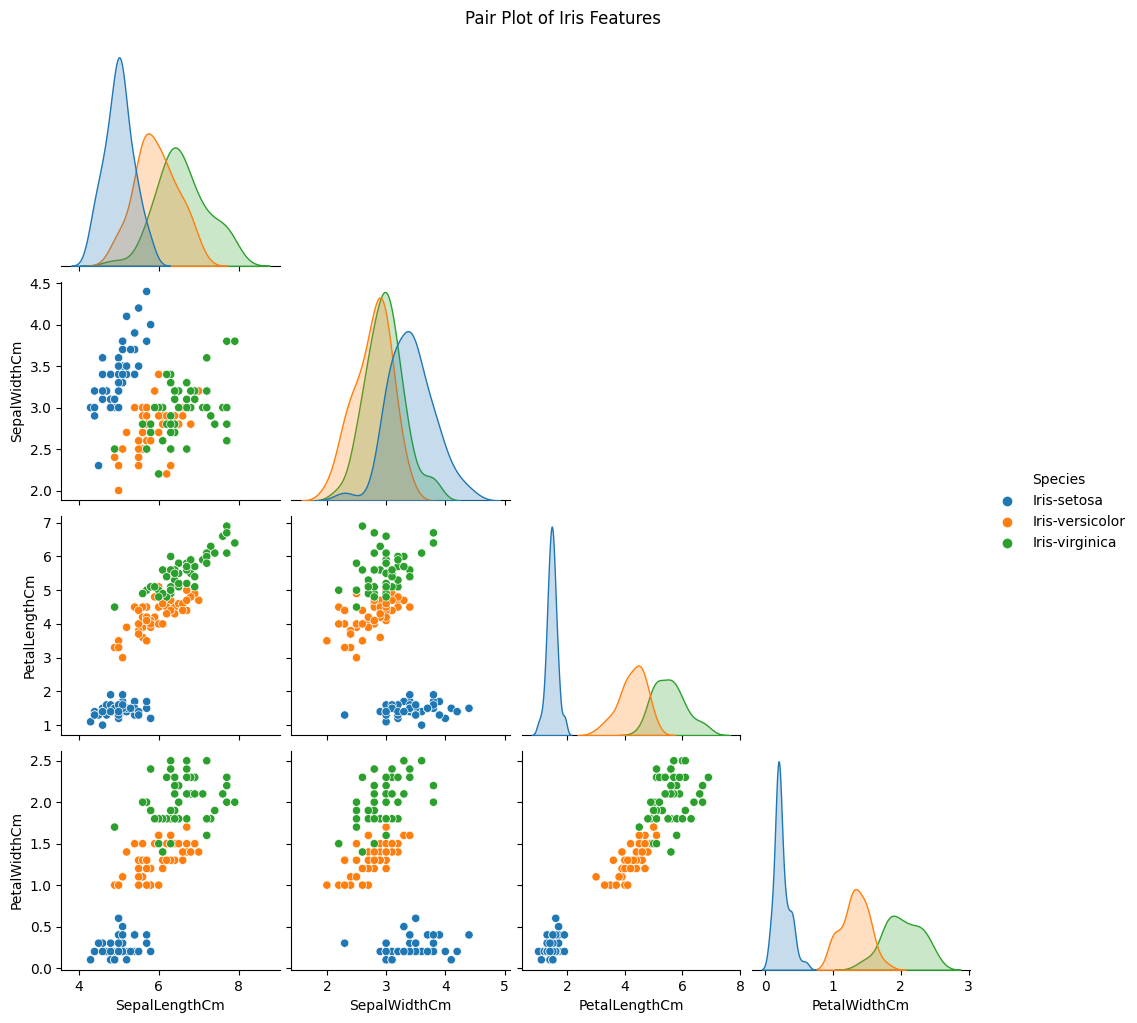

In [4]:
sns.pairplot(df, hue='Species', diag_kind='kde', corner=True)
plt.suptitle("Pair Plot of Iris Features", y=1.02)
plt.show()

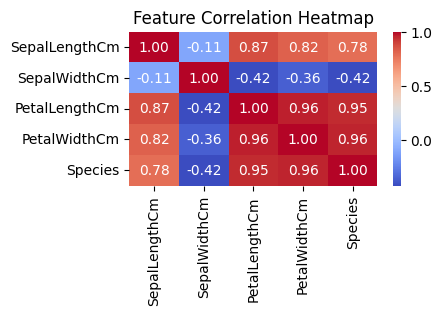

In [5]:
# Encode species for numeric correlation
df_encoded = df.copy()
df_encoded['Species'] = LabelEncoder().fit_transform(df['Species'])

plt.figure(figsize=(4, 2))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

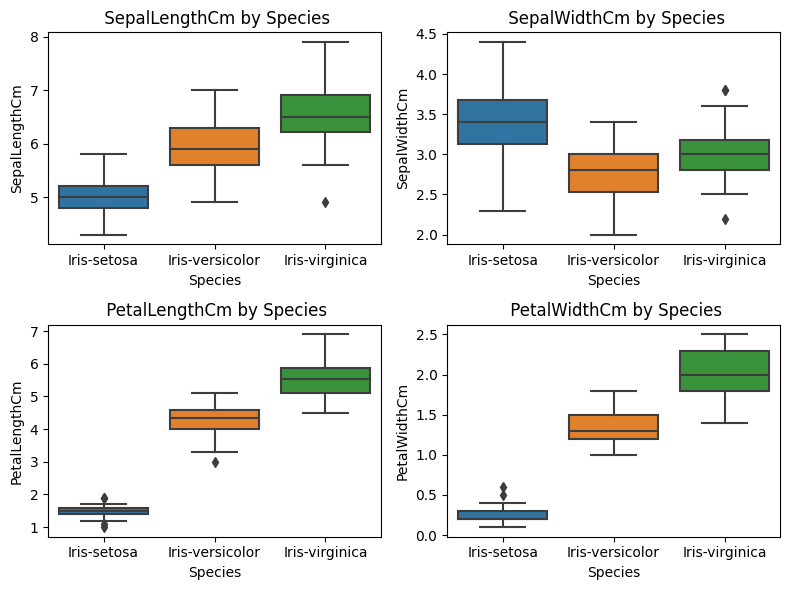

In [6]:
#One boxplot per feature
features = df.columns[:-1]

plt.figure(figsize=(8, 6))
for i, col in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, x="Species", y=col)
    plt.title(f" {col} by Species")
plt.tight_layout()
plt.show()

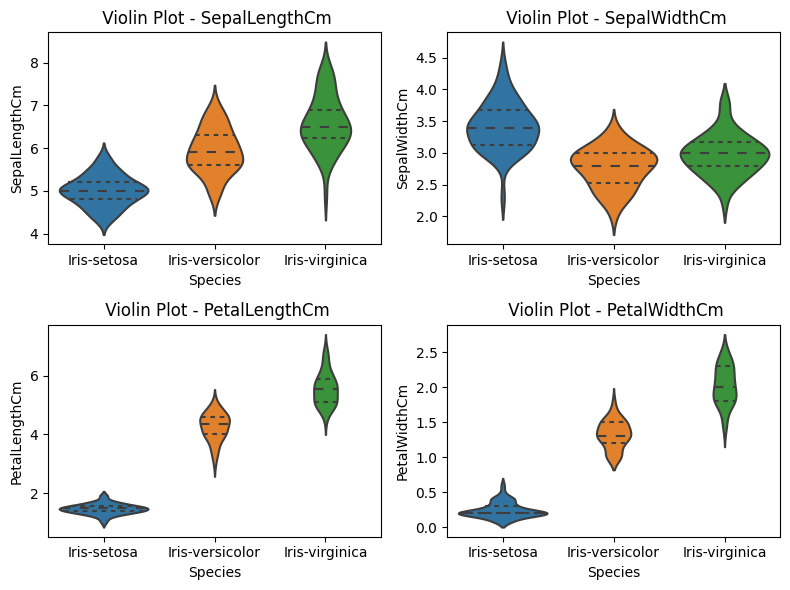

In [7]:
plt.figure(figsize=(8, 6))
for i, col in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.violinplot(data=df, x="Species", y=col, inner="quartile")
    plt.title(f" Violin Plot - {col}")
plt.tight_layout()
plt.show()

**Preprocess Dataset**

In [8]:
df.isnull().sum()

SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [9]:
# Encode target
le = LabelEncoder()
df["Species"] = le.fit_transform(df["Species"])

X = df.drop("Species", axis=1)
y = df["Species"]
#y_cat = to_categorical(y)

**Step 3: Train-Test Split and Scaling**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Step 4: ML Models Without Tuning**

In [12]:
ml_models_no_tune = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

In [13]:
ml_predictions_no_tuning = {}
print("ML Models Without Tuning:")

for name, model in ml_models_no_tune.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    ml_predictions_no_tuning[name] = preds
    acc = accuracy_score(y_test, preds)
    print(f"{name}: Accuracy = {acc:.4f}")

ML Models Without Tuning:
Random Forest: Accuracy = 1.0000
SVM: Accuracy = 1.0000
KNN: Accuracy = 1.0000
Logistic Regression: Accuracy = 1.0000
Decision Tree: Accuracy = 1.0000


**Step 5: ML model With Tuning**

In [14]:
ml_models_with_params = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {"n_estimators": [50, 100], "max_depth": [None, 5, 10]}
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42),
        "params": {"C": [0.1, 1, 10], "gamma": ['scale', 0.1]}
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [3, 5, 7], "weights": ['uniform', 'distance']}
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=200),
        "params": {"C": [0.1, 1, 10], "penalty": ['l2']}
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {"max_depth": [None, 5, 10], "criterion": ["gini", "entropy"]}
    }
}

In [15]:
ml_predictions_with_tuning = {}
print("\nML Models With Tuning:")

for name, config in ml_models_with_params.items():
    grid = GridSearchCV(config["model"], config["params"], cv=5, scoring='accuracy')
    grid.fit(X_train_scaled, y_train)
    best_model = grid.best_estimator_
    preds = best_model.predict(X_test_scaled)
    ml_predictions_with_tuning[name] = preds
    acc = accuracy_score(y_test, preds)
    print(f"{name}: Best Params = {grid.best_params_}, Accuracy = {acc:.4f}")


ML Models With Tuning:
Random Forest: Best Params = {'max_depth': None, 'n_estimators': 50}, Accuracy = 1.0000
SVM: Best Params = {'C': 10, 'gamma': 0.1}, Accuracy = 1.0000
KNN: Best Params = {'n_neighbors': 7, 'weights': 'distance'}, Accuracy = 1.0000
Logistic Regression: Best Params = {'C': 1, 'penalty': 'l2'}, Accuracy = 1.0000
Decision Tree: Best Params = {'criterion': 'entropy', 'max_depth': None}, Accuracy = 1.0000


**Step 6: Accuracy Comparison**

In [16]:
# Build accuracy comparison DataFrame
accuracy_data = []

for name in ml_models_no_tune.keys():
    acc_no_tune = accuracy_score(y_test, ml_predictions_no_tuning[name])
    acc_with_tune = accuracy_score(y_test, ml_predictions_with_tuning[name])
    accuracy_data.append({
        "Model": name,
        "Accuracy (No Tuning)": round(acc_no_tune, 4),
        "Accuracy (With Tuning)": round(acc_with_tune, 4)
    })

accuracy_df = pd.DataFrame(accuracy_data)
print("\nAccuracy Comparison DataFrame:")
print(accuracy_df)



Accuracy Comparison DataFrame:
                 Model  Accuracy (No Tuning)  Accuracy (With Tuning)
0        Random Forest                   1.0                     1.0
1                  SVM                   1.0                     1.0
2                  KNN                   1.0                     1.0
3  Logistic Regression                   1.0                     1.0
4        Decision Tree                   1.0                     1.0


**Predicted Data**

In [17]:
#true_labels = le.inverse_transform(y_test)
true_labels = le.inverse_transform(y_test)

# No tuning
df_no_tune = pd.DataFrame({"True Label": true_labels})
for name, preds in ml_predictions_no_tuning.items():
    df_no_tune[name + " Prediction"] = le.inverse_transform(preds)
df_no_tune.to_csv("iris_predictions_no_tuning.csv", index=False)

# With tuning
df_with_tune = pd.DataFrame({"True Label": true_labels})
for name, preds in ml_predictions_with_tuning.items():
    df_with_tune[name + " Prediction"] = le.inverse_transform(preds)
df_with_tune.to_csv("iris_predictions_with_tuning.csv", index=False)

print("\nSaved: iris_predictions_no_tuning.csv")
print("\nSaved: iris_predictions_with_tuning.csv")


Saved: iris_predictions_no_tuning.csv

Saved: iris_predictions_with_tuning.csv


In [18]:
df1 = pd.read_csv("/kaggle/working/iris_predictions_no_tuning.csv")
df2 = pd.read_csv("/kaggle/working/iris_predictions_with_tuning.csv")

In [19]:
df1.head()

,True Label,Random Forest Prediction,SVM Prediction,KNN Prediction,Logistic Regression Prediction,Decision Tree Prediction
0,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor
1,Iris-setosa,Iris-setosa,Iris-setosa,Iris-setosa,Iris-setosa,Iris-setosa
2,Iris-virginica,Iris-virginica,Iris-virginica,Iris-virginica,Iris-virginica,Iris-virginica
3,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor
4,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor


In [20]:
df2.head()

,True Label,Random Forest Prediction,SVM Prediction,KNN Prediction,Logistic Regression Prediction,Decision Tree Prediction
0,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor
1,Iris-setosa,Iris-setosa,Iris-setosa,Iris-setosa,Iris-setosa,Iris-setosa
2,Iris-virginica,Iris-virginica,Iris-virginica,Iris-virginica,Iris-virginica,Iris-virginica
3,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor
4,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor,Iris-versicolor
